# dogs VS cats


<br><li>Se abre la sesión en Colab</li>

In [36]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [37]:
print ('Files in Drive:')
!ls "/content/drive/My Drive/MDS/38_Deep Learning/practice/data"

Files in Drive:
catsVSdogs    img	      prueba		X_test.plk   Y_test.plk
cnd_dict.pkz  model1_fit.pkz  transformed_data	X_train.plk  Y_train.plk


Lastly, if you need any help on the usage of a Python function you can place the writing cursor over its name and press Caps+Shift to produce a pop-out with related documentation. This will only work inside code cells.<br><br>

Let's go!<br><br>

# Libraries

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import math
import glob
import os
from skimage.io import imread
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler
import random
from functools import reduce # to run reduce tool from mapReduce.
import gzip # to compress files
import pickle # to save files -fitted models
from keras.utils import np_utils # to make continuos variables categorical ones
from keras.callbacks import Callback
from keras.callbacks import History
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten
from keras.layers import GlobalAveragePooling2D
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

In [0]:
rnd= random.seed(77)
rnd_np= np.random.seed(77)

# Functions

### Load data

In [0]:
def file_load(dataset,animal,size,scaler_range):
    X,y = [],[]
    scaler= MinMaxScaler(feature_range= scaler_range)
    for file in glob.glob('/content/drive/My Drive/MDS/38_Deep Learning/practice/data/catsVSdogs/' + dataset + '/' + animal + '/*.jpg'):
        # get the X features
        image = imread(file)
        X.append(np.array([scaler.fit_transform(elem) for elem in resize(image, size, mode="reflect")]))
        # get the y labels
        if animal == 'cats':
            y.append(0)
        elif animal == 'dogs':
            y.append(1)
        else:
            y.append(99)
    return zip(X,y)

### Sort a list

In [0]:
def sortList(x,positionList):
    return [x[pos] for pos in positionList]

### Save compressed file

In [0]:
def compressedFileSave(pathName,fileName,fileExtension,variable):
    if fileExtension=='pkz':
      f = gzip.open(pathName+fileName+'.'+fileExtension, mode='wb', compresslevel=9)
    elif fileExtension == 'plk':
      f = open(pathName+fileName+'.'+fileExtension, mode='wb', compresslevel=9)
    pickle.dump(variable, f, protocol=3)
    f.close()

### Load compressed file

In [0]:
def compressedFileLoad(pathName,fileName,fileExtension):
    if fileExtension=='pkz':
      f = gzip.open(pathName+fileName+'.'+fileExtension, mode='rb')
    elif fileExtension == 'plk':
      f = open(pathName+fileName+'.'+fileExtension, mode='rb')
    aux = pickle.load(f)
    f.close()
    return aux

### Plot Confusion Matrix

In [0]:
def plot_confusion_matrix(cm, dim, model):
  #plt.figure( figsize=(6, 4))
  n_colors = 2
  cMap = plt.cm.get_cmap("tab20c", lut=n_colors ) 

  vmax= dim
  plt.title('Model Confusion Matrix for '+ model)
  h_map = sns.heatmap(cm,
                      vmin=0, vmax= vmax,
                      cmap=cMap, 
                      annot=True,
                      fmt=".0f")

  cbar = h_map.collections[0].colorbar
  l_ticks = [0,vmax/2,vmax]
  cbar.set_ticks(l_ticks)

### Loss History Class

In [0]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# Data processing
The images to use in this assignment are available here. Download the data package and extract it into a folder in your computer.<br><br>

Data is structured under two folders, train and test. You are only allowed to use the test data to measure the performance of your model after you have finished training. Both train and test folders contain one subfolder per class (cats and dogs).<br><br>

The recommended way to load an image from disk is to use the imread function from the scikit-image library. For example:<br><br>

## Example

In [0]:
from skimage.io import imread

image = imread("/content/drive/My Drive/MDS/38_Deep Learning/practice/data/img/sample.jpg")

This returns the image as 3-dimensional numpy matrix, containing the value of intensity of every pixel in each row, column and color channel.

In [47]:
image.shape

(499, 367, 3)

We can visualize the loaded image using

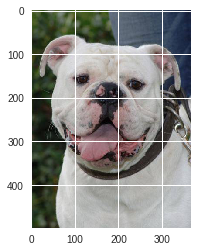

In [48]:
plt.imshow(image)

The dataset includes 20000 training images and 5000 test images, each image at a different resolution. Loading all this data at once requires too much memory, so we will need to resize each image to a smaller, common size as we load them from disk. We can do so by again making use of a scikit-image function. For example:

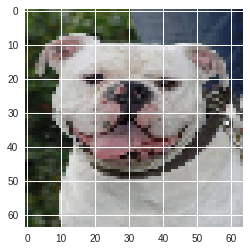

In [49]:
from skimage.transform import resize

size = 64
smallimage = resize(image, (64, 64, 3), mode="reflect")  # 64 x 64 pixels, 3 color channels
plt.imshow(smallimage)

***

<font color=#ad3e26>
    
Perform the following tasks to prepare the data:
- Build a numpy array *X_train* containing one entry for each training image in the data. Each entry must contain the 3-dimensional matrix of pixels corresponding to an image. Make sure to scale down each image to a common size
- Normalize *X_train* so that pixels follow a distribution lying in the range [-0.5,0.5]
- Build a corresponding array *Y_train* with the class of each training image (0 for cats and 1 for dogs).
- Randomly shuffle the data. Make sure you shuffle both *X_train* and *Y_train* using the same permutation, so you don't lose track of the class of each training pattern.

- Repeat the whole procedure again to generate *X_test* and *Y_test* matrices for the test data.
</font>

***

***
<font color=#2655ad>
- Take advantage of the *glob* package to generate the filename lists for the indoor and outdoor subfolders.
- Since you need to repeat the procedure both for training and test data, it would be useful to implement a function that performs all the data loading and transforming steps.
</font>

***

## Load data set

<br><li>Se obtiene un dictionario con las imágenes y su label, 0 o 1 según corresponda a <i>cat</i> o <i>dog</i>. Además, se escala al rango (-0.5,0.5)</li>

In [0]:
#datasetList= ['train','test']
#animalList= ['cats','dogs']
#size= (64, 64, 3)
#scaler_range= (-0.5,0.5)
#cnd_dict={
#    dataset:{
#        animal:{
#            'X': [elem[0] for elem in list(file_load(dataset,animal,size,scaler_range))],
#            'y': [elem[1] for elem in list(file_load(dataset,animal,size,scaler_range))]
#        }
#        for animal in animalList
#    } 
#    for dataset in datasetList
#}

<br><li>Comprobación</li>


In [0]:
#len(cnd_dict['train']['cats']['X']) == 20000,len(cnd_dict['train']['cats']['y']) == 20000,\
#len(cnd_dict['train']['dogs']['X']) == 20000,len(cnd_dict['train']['dogs']['y']) == 20000,\
#len(cnd_dict['test']['cats']['X']) == 5000,len(cnd_dict['test']['cats']['y']) == 5000,\
#len(cnd_dict['test']['dogs']['X']) == 5000,len(cnd_dict['test']['dogs']['y']) == 5000

<br>
<li>Guardado del diccionario.</li>

In [0]:
#variable= cnd_dict
#fileName= 'cnd_dict'
#fileExtension='pkz'
#pathName= '/content/drive/My Drive/MDS/38_Deep Learning/practice/data/'
#compressedFileSave(pathName,fileName,fileExtension,variable)

<br>
<li>Carga del diccionario.</li>

In [0]:
#fileName= 'cnd_dict'
#pathName= '/content/drive/My Drive/MDS/38_Deep Learning/practice/data/'
#cnd_dict=compressedFileLoad(pathName,fileName)

In [0]:
#len(cnd_dict['train']['cats']['X'])==10000,len(cnd_dict['train']['cats']['y'])==10000,len(cnd_dict['train']['dogs']['X'])==10000,len(cnd_dict['train']['dogs']['y'])==10000,\
#len(cnd_dict['test']['cats']['X'])==2500,len(cnd_dict['test']['cats']['y'])==2500,len(cnd_dict['test']['dogs']['X'])==2500,len(cnd_dict['test']['dogs']['y'])==2500

In [0]:
#fileName= 'cnd_dict'
#pathName= '/content/drive/My Drive/MDS/38_Deep Learning/practice/data/'
#fileExtension='pkz'
#cnd_dict= compressedFileLoad(pathName,fileName,fileExtension)

## Training and Testing data set

<br>
<li>Se construye el training y testing data set y se realiza el shuffle a nivel indice entre <i>cat</i> y <i>dog</i>.</li>

In [0]:
#X_train_orig, y_train_orig= reduce(lambda x,y: x+y, [cnd_dict['train'][animal]['X'] for animal in animalList]), reduce(lambda x,y: x+y, [cnd_dict['train'][animal]['y'] for animal in animalList])
#train_index= list(range(len(X_train_orig)))
#train_index_shff= train_index
#random.shuffle(train_index_shff)
#X_train,y_train= [sortList(elem,train_index_shff) for elem in [X_train_orig, y_train_orig]]
#X_train,y_train= np.array(X_train),np.array(y_train)

In [0]:
#X_test_orig, y_test_orign= reduce(lambda x,y: x+y, [cnd_dict['test'][animal]['X'] for animal in animalList]), reduce(lambda x,y: x+y, [cnd_dict['test'][animal]['y'] for animal in animalList])
#X_test_orig, y_test_orig= reduce(lambda x,y: x+y, [cnd_dict['test'][animal]['X'] for animal in animalList]), reduce(lambda x,y: x+y, [cnd_dict['test'][animal]['y'] for animal in animalList])
#test_index= list(range(len(X_test_orig)))
#test_index_shff= test_index
#random.shuffle(test_index_shff)
#X_test,y_test= [sortList(elem,test_index_shff) for elem in [X_test_orig, y_test_orig]]
#X_test,y_test= np.array(X_test),np.array(y_test)

<br><li>Guardado de los data sets.</li>

In [0]:
#variable_list= [X_train,y_train,X_test,y_test]
#fileName_list= ['X_train','y_train','X_test','y_test']
#fileExtension='pkz'
#pathName= '/content/drive/My Drive/MDS/38_Deep Learning/practice/data/'
#_=[compressedFileSave(pathName,fileName,fileExtension,variable) for fileName, variable in zip(fileName_list,variable_list)]

<br><li>Carga de los data sets.</li>

In [0]:
pathName= '/content/drive/My Drive/MDS/38_Deep Learning/practice/data/'
fileName_list= ['X_train','Y_train','X_test','Y_test']
fileExtension='plk'
X_train_orig= compressedFileLoad(pathName,fileName_list[0],fileExtension)
y_train_orig= compressedFileLoad(pathName,fileName_list[1],fileExtension)
X_test_orig= compressedFileLoad(pathName,fileName_list[2],fileExtension)
y_test_orig= compressedFileLoad(pathName,fileName_list[3],fileExtension)

<br>
If everything has been properly loaded both X_train and Y_train lists should have equal length, and the same should happen for the pair X_test and Y_test.

In [60]:
print("X_train size", len(X_train_orig))
print("y_train size", len(y_train_orig))
print("X_test size", len(X_test_orig))
print("y_test size", len(y_test_orig))

X_train size 20000
y_train size 20000
X_test size 5000
y_test size 5000


<br>

<br> <li>Comprobación de la carga del número patrones y del orden aleatorio.</li>

In [61]:
len(X_train_orig)==20000,len(y_train_orig)==20000,len(X_test_orig)==5000,len(y_test_orig)==5000

(True, True, True, True)

In [62]:
y_train_orig[0:20]

[0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0]

In [63]:
y_test_orig[0:20]

[1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0]

* Formatting the data as tensors.<br>
Se transforma el data set de la imágenes de array 64x64x3 en un array para trabajar con tensores cuyo formato es:
> 1.   Image index (e.g. 3th image in the dataset)
> 2.   Row index
> 3.   Column index
> 4.   Channel index (e.g. colour channel in colored images)

In [0]:
X_train = X_train_orig.astype('float32')
X_test = X_test_orig.astype('float32')
Y_train = np_utils.to_categorical(y_train_orig, 2) # We have 10 classes to codify
Y_test = np_utils.to_categorical(y_test_orig, 2)

In [0]:
trainImageIndex= len(X_train)
testImageIndex= len(X_test)
rowIndex= X_train[0].shape[0]
columnIndex= X_train[0].shape[1]
channelIndex= X_train[0].shape[2]

traintensor = X_train.reshape(trainImageIndex, rowIndex, columnIndex, channelIndex)
testtensor = X_test.reshape(testImageIndex, rowIndex, columnIndex, channelIndex)

# Basic deep model

## Model 1

<br><li>Diseño de la arquitectura del modelo</li>

El modelo consitirá en un modelo secuencial (la ejecución se realiza capa tras capa sin posibilidad de saltos ni de ejecución simultánea) con las siguientes capas:
<li> Capa input.</li>

> Las imagenes reducidas a 64x64 x3 channels (RGB). Se introduce en la primera capa de convolución en el parámetro input_shape.


<li> Capa convolución.</li>

> Transforma la imagén según el kernel elegido. Cada kernel se ejecuta en todos los channels a la vez dando como resultado una imagen plana, es decir, con un único channel, por tanto, el output de la convolución serán una imagen filtrada con tantos channels como kernel ejecutados sobre ella.<br>
El objetivo del kernel es reconocer una parte de la imagen como puedan ser las líneas rectas verticales, diagonales, caras, etc.

> padding: se opta por valid que reduce el tamaño de la foto en función de los píxeles que son NA en el kernel. En este caso, como el kernel es de 3x3 se reduce en 2 píxeles por capa de convolución.

<li>Activación.</li>

> Realiza la transformación no-lineal del modelo. Se escoge ReLu para evitar posibles problemas de valores cercanos a cero de la derivada primera en el back-propagation, que no permitiría mejorar el modelo en dicha pasada.

<li> Capa pooling.</li>

> Reduce el tamaño el tamaño de la imagen en función de la región establecida, obteniendo el valor principal de la estadística seleccionada de dicha región. Normalmente, suele ser el valor máximo como sea escogido en esta ocasión.

<li> Técnica de <i>dropout</i>.</li>

> Técnica que reduce el overfitting, ocasionado por las numerosas capas que generan pesos nuevos, anulando aleatoriamente un número preestablecido de neuronas, en esta ocasión 25%. Esta técnica obliga al modelo a adaptarse, a aprender de distintas situaciones. Es decir, es una manera de generalizar el modelo y no permitirle que se aprenda el training set ya que al no contar con las mismas neuronas en cada época y tener que seguir clasificando bien la neuronas no se especializan tanto no pudiendo aprenderse el training set.

<li>Capa flatten.</li>

> Que combina los distintos channels en uno solo para poder trabajar con capas densas propias de las redes neuronales.

<li>Capa densa.</li>

> Una capa clásica de las redes neuronales. En este caso es la capa output.<br>

<li>Activación.</li>

> Al igual que se ha mencionado antes, realiza la transformación no-lineal del modelo.<br>

Para la **capa output** y su activación, habría dos posibilidades:

1.   Capa densa con 2 neuronas + activación *softMax* para normalizar a las dos posibles clases.
2.   Capa densa con 1 neurona + activación *sigmoide* que define una clase binaria.





<br>

> 1.   Opción: Capa densa con 2 neuronas + activación softMax



In [0]:
img_rows = X_train[0].shape[0]
img_cols = X_train[0].shape[1]
img_channels= X_train[0].shape[2]
kernel_size = 3 # Size of the kernel for the convolution layers
pool_size = 2 # Size of the pooling region for the pooling layers

model1 = Sequential()

model1.add(Convolution2D(32, # Number convolution channels to generate
                        (kernel_size, kernel_size), # Size of convolution kernels
                        padding='valid', # Strategy to deal with borders
                        input_shape=(img_rows, img_cols, img_channels))) # Size = image rows x image columns x channels
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dense(2))
model1.add(Activation('softmax'))

<br><li>Compilación y entrenamiento del modelo</li>

In [67]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_loss = LossHistory()
history= History()
model1_fit= model1.fit(
    traintensor, # Training data
    Y_train, # Labels of training data
    batch_size=128, # Batch size for the optimizer algorithm
    epochs=20, # Number of epochs to run the optimizer algorithm
    verbose=1, # Level of verbosity of the log messages
    callbacks=[history] # to record the epochs logs
)

Epoch 1/20
20000/20000 [==============================] - 2s 122us/step - loss: 0.6160 - acc: 0.6597
Epoch 2/20
20000/20000 [==============================] - 2s 109us/step - loss: 0.5342 - acc: 0.7328
Epoch 3/20
20000/20000 [==============================] - 2s 109us/step - loss: 0.4928 - acc: 0.7637
Epoch 4/20
20000/20000 [==============================] - 2s 108us/step - loss: 0.4581 - acc: 0.7881
Epoch 5/20
20000/20000 [==============================] - 2s 109us/step - loss: 0.4466 - acc: 0.7957
Epoch 6/20
20000/20000 [==============================] - 2s 110us/step - loss: 0.4277 - acc: 0.8035
Epoch 7/20
20000/20000 [==============================] - 2s 111us/step - loss: 0.4075 - acc: 0.8203
Epoch 8/20
20000/20000 [==============================] - 2s 108us/step - loss: 0.3924 - acc: 0.8238
Epoch 9/20
20000/20000 [==============================] - 2s 107us/step - loss: 0.3833 - acc: 0.8293
Epoch 10/20
20000/20000 [==============================] - 2s 109us/step - loss: 0.3711 - a

In [68]:
model1_fit.history.keys()

dict_keys(['loss', 'acc'])

<br><li>Se guarda el modelo</li>

In [0]:
pathName='/content/drive/My Drive/MDS/38_Deep Learning/practice/data/'
fileName='model1_fit'
fileExtension='pkz'
variable= model1_fit
compressedFileSave(pathName,fileName,fileExtension,variable)

<br><li>Cálculo del performance y predicciones del modelo</li>

In [70]:
train_accuracy = model1.evaluate(traintensor, Y_train)[1]
score = model1.evaluate(testtensor, Y_test)
try:
  df_score=df_score.reindex(index = ['Test loss','Test accuracy','Train accuracy'])
  df_score["model1"]= [score[0],score[1],train_accuracy]
except:
  df_score= pd.DataFrame.from_dict({"model1":
                                   {
                                       "Test loss":score[0],
                                       "Test accuracy": score[1],
                                       "Train accuracy": train_accuracy
                                   }
                                   })

Y_pred_model1 =  model1.predict_classes(testtensor)   
print("Test loss", score[0])
print("Test accuracy", score[1])

5000/5000 [==============================] - 1s 100us/step
Test loss 0.5230520223140717
Test accuracy 0.7734


<br><li>Se guarda el history del training</li>

In [0]:
df_epochs_model1= pd.DataFrame.from_dict({
    'epoch': range(len(model1_fit.history['acc'])),
    'acc': model1_fit.history['acc'],
    'loss': model1_fit.history['loss']})

## Model 2

<br>

> 2.   Opción: Se realizan los siguientes cambios:<br>
>> Capa densa (500)<br>
>> Capa drpout para regularizar al meter 500 neuronas en la capa densa<br>
>> Capa output densa (2)<br>
>> Activación *sigmoide*<br>

<br><li>Diseño de la arquitectura del modelo</li>

In [0]:
img_rows = X_train[0].shape[0]
img_cols = X_train[0].shape[1]
img_channels= X_train[0].shape[2]
kernel_size = 3 # Size of the kernel for the convolution layers
pool_size = 2 # Size of the pooling region for the pooling layers

model2 = Sequential()

model2.add(Convolution2D(32, # Number convolution channels to generate
                        (kernel_size, kernel_size), # Size of convolution kernels
                        padding='valid', # Strategy to deal with borders
                        input_shape=(img_rows, img_cols, img_channels))) # Size = image rows x image columns x channels
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(500))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(2))
model2.add(Activation('sigmoid'))

<br><li>Compilación y entrenamiento del modelo</li>

In [79]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2_fit= model2.fit(
    traintensor, # Training data
    Y_train, # Labels of training data
    batch_size=128, # Batch size for the optimizer algorithm
    epochs=20, # Number of epochs to run the optimizer algorithm
    verbose=1, # Level of verbosity of the log messages
    callbacks=[history] # to record the epochs logs
    )

Epoch 1/20
20000/20000 [==============================] - 5s 244us/step - loss: 0.0897 - acc: 0.9681
Epoch 2/20
20000/20000 [==============================] - 4s 203us/step - loss: 0.0786 - acc: 0.9709
Epoch 3/20
20000/20000 [==============================] - 4s 200us/step - loss: 0.0814 - acc: 0.9709
Epoch 4/20
20000/20000 [==============================] - 4s 199us/step - loss: 0.0797 - acc: 0.9719
Epoch 5/20
20000/20000 [==============================] - 4s 199us/step - loss: 0.0721 - acc: 0.9743
Epoch 6/20
20000/20000 [==============================] - 4s 201us/step - loss: 0.0691 - acc: 0.9761
Epoch 7/20
20000/20000 [==============================] - 4s 201us/step - loss: 0.0718 - acc: 0.9739
Epoch 8/20
20000/20000 [==============================] - 4s 200us/step - loss: 0.0634 - acc: 0.9767
Epoch 9/20
20000/20000 [==============================] - 4s 197us/step - loss: 0.0607 - acc: 0.9791
Epoch 10/20
20000/20000 [==============================] - 4s 200us/step - loss: 0.0611 - a

<br><li>Se guarda el modelo</li>

In [0]:
pathName='/content/drive/My Drive/MDS/38_Deep Learning/practice/data/'
fileName='model2_fit'
fileExtension='pkz'
variable=model2
compressedFileSave(pathName,fileName,fileExtension,variable)

<br><li>Cálculo del performance del modelo</li>

In [81]:
train_accuracy = model2.evaluate(traintensor, Y_train)[1]
score = model2.evaluate(testtensor, Y_test)
try:
  df_score=df_score.reindex(index = ['Test loss','Test accuracy','Train accuracy'])
  df_score["model2"]= [score[0],score[1],train_accuracy]
except:
  df_score= pd.DataFrame.from_dict({"model2":
                                   {
                                       "Test loss":score[0],
                                       "Test accuracy": score[1],
                                       "Train accuracy": train_accuracy
                                   }
                                   })

Y_pred_model2 =  model2.predict_classes(testtensor)   
print("Test loss", score[0])
print("Test accuracy", score[1])

5000/5000 [==============================] - 0s 95us/step
Test loss 0.9754269641399383
Test accuracy 0.7794


<br><li>Se guarda el history del training</li>

In [0]:
df_epochs_model2= pd.DataFrame.from_dict({
    'epoch': range(len(model2_fit.history['acc'])),
    'acc': model2_fit.history['acc'],
    'loss': model2_fit.history['loss']})

## Model 3

<br>

> 3.   Opción: model2 cambiando el método del pooling a average.

<br><li>Diseño de la arquitectura del modelo</li>

In [0]:
img_rows = X_train[0].shape[0]
img_cols = X_train[0].shape[1]
img_channels= X_train[0].shape[2]
kernel_size = 3 # Size of the kernel for the convolution layers
pool_size = 2 # Size of the pooling region for the pooling layers

model3 = Sequential()

model3.add(Convolution2D(32, # Number convolution channels to generate
                        (kernel_size, kernel_size), # Size of convolution kernels
                        padding='valid', # Strategy to deal with borders
                        input_shape=(img_rows, img_cols, img_channels))) # Size = image rows x image columns x channels
model3.add(Activation('relu'))
model3.add(AveragePooling2D(pool_size=(pool_size, pool_size)))
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(500))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(2))
model3.add(Activation('sigmoid'))

<br><li>Compilación y entrenamiento del modelo</li>

In [84]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3_fit=model3.fit(
    traintensor, # Training data
    Y_train, # Labels of training data
    batch_size=128, # Batch size for the optimizer algorithm
    epochs=20, # Number of epochs to run the optimizer algorithm
    verbose=1, # Level of verbosity of the log messages
    callbacks=[history] # to record the epochs logs
    )

Epoch 1/20
20000/20000 [==============================] - 5s 241us/step - loss: 0.6420 - acc: 0.6382
Epoch 2/20
20000/20000 [==============================] - 4s 203us/step - loss: 0.5630 - acc: 0.7111
Epoch 3/20
20000/20000 [==============================] - 4s 200us/step - loss: 0.5157 - acc: 0.7443
Epoch 4/20
20000/20000 [==============================] - 4s 198us/step - loss: 0.4772 - acc: 0.7709
Epoch 5/20
20000/20000 [==============================] - 4s 200us/step - loss: 0.4439 - acc: 0.7897
Epoch 6/20
20000/20000 [==============================] - 4s 200us/step - loss: 0.4093 - acc: 0.8168
Epoch 7/20
20000/20000 [==============================] - 4s 202us/step - loss: 0.3766 - acc: 0.8344
Epoch 8/20
20000/20000 [==============================] - 4s 200us/step - loss: 0.3523 - acc: 0.8447
Epoch 9/20
20000/20000 [==============================] - 4s 199us/step - loss: 0.3283 - acc: 0.8591
Epoch 10/20
20000/20000 [==============================] - 4s 199us/step - loss: 0.3019 - a

<br><li>Se guarda el modelo</li>

In [0]:
pathName='/content/drive/My Drive/MDS/38_Deep Learning/practice/data/'
fileName='model3_fit'
fileExtension='pkz'
variable=model3
compressedFileSave(pathName,fileName,fileExtension,variable)

<br><li>Cálculo del performance del modelo</li>

In [86]:
train_accuracy = model3.evaluate(traintensor, Y_train)[1]
score = model3.evaluate(testtensor, Y_test)
try:
  df_score=df_score.reindex(index = ['Test loss','Test accuracy','Train accuracy'])
  df_score["model3"]= [score[0],score[1],train_accuracy]
except:
  df_score= pd.DataFrame.from_dict({"model3":
                                   {
                                       "Test loss":score[0],
                                       "Test accuracy": score[1],
                                       "Train accuracy": train_accuracy
                                   }
                                   })

Y_pred_model3 =  model3.predict_classes(testtensor)   
print("Test loss", score[0])
print("Test accuracy", score[1])

5000/5000 [==============================] - 0s 88us/step
Test loss 0.6440624290943145
Test accuracy 0.7685


<br><li>Se guarda el history del training</li>

In [0]:
df_epochs_model3= pd.DataFrame.from_dict({
    'epoch': range(len(model3_fit.history['acc'])),
    'acc': model3_fit.history['acc'],
    'loss': model3_fit.history['loss']})

# Improving the network

## LeNet

<br>

> 1.   Opción: Sin early Stopping

*   Diseño de la arquitectura del modelo :

     1. A Convolution layer of 20 channels, kernel size 5 and rectified linear activation
     2. A MaxPooling layer of size 2 and stride 2
     3. A 25% Dropout
     4. A Convolution layer of 50 channels, kernel size 5 and rectified linear activation
     5. A MaxPooling layer of size 2 and stride 2
     6. A 25% Dropout
     7. A Flatten layer
     8. A Dense layer with 500 units and rectified linear activation
     9. A 50% Dropout
     10. An output Dense layer with softmax activation


In [0]:
img_rows = X_train[0].shape[0]
img_cols = X_train[0].shape[1]
img_channels= X_train[0].shape[2]

LeNet = Sequential()

LeNet.add(Convolution2D(20, (5, 5),
                        padding='valid',
                        input_shape=(img_rows, img_cols, img_channels)))
LeNet.add(Activation('relu'))
LeNet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
LeNet.add(Dropout(0.25))
LeNet.add(Convolution2D(50, (5, 5)))
LeNet.add(Activation('relu'))
LeNet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
LeNet.add(Dropout(0.25))
LeNet.add(Flatten())
LeNet.add(Dense(500))
LeNet.add(Activation('relu'))
LeNet.add(Dropout(0.5))
LeNet.add(Dense(2))
LeNet.add(Activation('sigmoid'))

<br><li>Compilación del modelo</li>

In [89]:
LeNet.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
LeNet_fit= LeNet.fit(
    traintensor, # Training data
    Y_train, # Labels of training data
    batch_size=128, # Batch size for the optimizer algorithm
    epochs=64, # Number of epochs to run the optimizer algorithm
    verbose=1, # Level of verbosity of the log messages
    callbacks=[history] # to record the epochs logs
    )

Epoch 1/64
20000/20000 [==============================] - 4s 213us/step - loss: 0.6488 - acc: 0.6111
Epoch 2/64
20000/20000 [==============================] - 3s 173us/step - loss: 0.5527 - acc: 0.7140
Epoch 3/64
20000/20000 [==============================] - 3s 167us/step - loss: 0.4988 - acc: 0.7551
Epoch 4/64
20000/20000 [==============================] - 3s 170us/step - loss: 0.4713 - acc: 0.7772
Epoch 5/64
20000/20000 [==============================] - 3s 167us/step - loss: 0.4343 - acc: 0.7974
Epoch 6/64
20000/20000 [==============================] - 3s 166us/step - loss: 0.4061 - acc: 0.8145
Epoch 7/64
20000/20000 [==============================] - 3s 171us/step - loss: 0.3786 - acc: 0.8293
Epoch 8/64
20000/20000 [==============================] - 3s 173us/step - loss: 0.3549 - acc: 0.8438
Epoch 9/64
20000/20000 [==============================] - 3s 171us/step - loss: 0.3241 - acc: 0.8590
Epoch 10/64
20000/20000 [==============================] - 3s 171us/step - loss: 0.2940 - a

<br><li>Se guarda el modelo</li>

In [0]:
pathName='/content/drive/My Drive/MDS/38_Deep Learning/practice/data/'
fileName='LeNet_fit'
fileExtension='pkz'
variable=LeNet
compressedFileSave(pathName,fileName,fileExtension,variable)

<br><li>Cálculo del performance del modelo</li>

In [91]:
train_accuracy = LeNet.evaluate(traintensor, Y_train)[1]
score = LeNet.evaluate(testtensor, Y_test)
try:
  df_score=df_score.reindex(index = ['Test loss','Test accuracy','Train accuracy'])
  df_score["LeNet"]= [score[0],score[1],train_accuracy]
except:
  df_score= pd.DataFrame.from_dict({"LeNet":
                                   {
                                       "Test loss":score[0],
                                       "Test accuracy": score[1],
                                       "Train accuracy": train_accuracy
                                   }
                                   })

Y_pred_LeNet =  LeNet.predict_classes(testtensor) 
print("Test loss", score[0])
print("Test accuracy", score[1])

5000/5000 [==============================] - 1s 118us/step
Test loss 0.7622267841637135
Test accuracy 0.8296


<br><li>Se guarda el history del training</li>

In [0]:
df_epochs_LeNet= pd.DataFrame.from_dict({
    'epoch': range(len(LeNet_fit.history['acc'])),
    'acc': LeNet_fit.history['acc'],
    'loss': LeNet_fit.history['loss']})

<br>

## Early Stopping strategy

>> Se comprueba que la técnica *early stopping* detiene la ejecución del modelo, según los parámetros definidos, reduciendo el overfitting del modelo.


<br><li>Técnica Early stopping.</li>

> Esta técnica detiene el entrenamiento del modelo cuando se cumplen ciertos criterios establecidos reduciendo la probabilidad de overfitting ya que no se le deja al modelo seguir entrenando, es decir, aprendiendo y ajustándose al training set.<br>
Los criterios de parada son enfunción de la variación de la función de pérdida, cuando esta no mejora en un valor determinado y/o no se produce una mejora en k épocas consecutivas.<br>
Para el uso de esta técnica es preciso utilizar cross-validation para tener un grupo de validación donde chequear lo mencionado.

> Configuración:<br>
- *min_delta*: 0. Mejora mínima de la función de pérdida.<br>
- *patience*: 3. Número de épocas sin la mejora mínima en la función de pérdida.

<br><li>Cross-Validation.</li>

> Configuración: 30%


In [0]:
#Early Stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',
                   min_delta=0, # threshold to whether quantify a loss at some epoch as improvement or not
                   patience=4, #number of epochs before stopping once your loss starts to increase (stops improving)
                   verbose=0, 
                   mode='auto',#what direction your monitored quantity has (is it supposed to be decreasing or increasing
                   baseline=None) 

<br><li>Diseño de la arquitectura del modelo</li>

In [0]:
img_rows = X_train[0].shape[0]
img_cols = X_train[0].shape[1]
img_channels= X_train[0].shape[2]

LeNet_es = Sequential()

LeNet_es.add(Convolution2D(20, (5, 5),
                        padding='valid',
                        input_shape=(img_rows, img_cols, img_channels)))
LeNet_es.add(Activation('relu'))
LeNet_es.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
LeNet_es.add(Dropout(0.25))
LeNet_es.add(Convolution2D(50, (5, 5)))
LeNet_es.add(Activation('relu'))
LeNet_es.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
LeNet_es.add(Dropout(0.25))
LeNet_es.add(Flatten())
LeNet_es.add(Dense(500))
LeNet_es.add(Activation('relu'))
LeNet_es.add(Dropout(0.5))
LeNet_es.add(Dense(2))
LeNet_es.add(Activation('sigmoid'))

<br><li>Compilación y entrenamiento del modelo</li>

In [95]:
LeNet_es.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
LeNet_es_fit= LeNet_es.fit(traintensor,
             Y_train,
             batch_size=128,
             epochs=64,
             verbose=1,
             validation_split=0.3,
             callbacks=[es, history]
)

Train on 14000 samples, validate on 6000 samples
Epoch 1/64
14000/14000 [==============================] - 4s 275us/step - loss: 0.6874 - acc: 0.5617 - val_loss: 0.6559 - val_acc: 0.6124
Epoch 2/64
14000/14000 [==============================] - 3s 191us/step - loss: 0.6140 - acc: 0.6636 - val_loss: 0.5831 - val_acc: 0.6996
Epoch 3/64
14000/14000 [==============================] - 3s 187us/step - loss: 0.5498 - acc: 0.7232 - val_loss: 0.5289 - val_acc: 0.7364
Epoch 4/64
14000/14000 [==============================] - 3s 188us/step - loss: 0.5080 - acc: 0.7516 - val_loss: 0.5315 - val_acc: 0.7377
Epoch 5/64
14000/14000 [==============================] - 3s 189us/step - loss: 0.4745 - acc: 0.7784 - val_loss: 0.4738 - val_acc: 0.7781
Epoch 6/64
14000/14000 [==============================] - 3s 191us/step - loss: 0.4433 - acc: 0.7940 - val_loss: 0.4865 - val_acc: 0.7664
Epoch 7/64
14000/14000 [==============================] - 3s 188us/step - loss: 0.4155 - acc: 0.8101 - val_loss: 0.4434 - v

<br><li>Se guarda el modelo</li>

In [0]:
pathName='/content/drive/My Drive/MDS/38_Deep Learning/practice/data/'
fileName='LeNet_es_fit'
fileExtension='pkz'
variable=LeNet_es
compressedFileSave(pathName,fileName,fileExtension,variable)

<br><li>Cálculo del performance del modelo</li>

In [97]:
train_accuracy = LeNet_es.evaluate(traintensor, Y_train)[1]
score = LeNet_es.evaluate(testtensor, Y_test)
try:
  df_score=df_score.reindex(index = ['Test loss','Test accuracy','Train accuracy'])
  df_score["LeNet_es"]= [score[0],score[1],train_accuracy]
except:
  df_score= pd.DataFrame.from_dict({"LeNet_es":
                                   {
                                       "Test loss":score[0],
                                       "Test accuracy": score[1],
                                       "Train accuracy": train_accuracy
                                   }
                                   })

Y_pred_LeNet_es =  LeNet_es.predict_classes(testtensor)   
print("Test loss", score[0])
print("Test accuracy", score[1])

5000/5000 [==============================] - 1s 107us/step
Test loss 0.4637125474452972
Test accuracy 0.8005


<br><li>Se guarda el history del training</li>

In [0]:
df_epochs_LeNet_es= pd.DataFrame.from_dict({
    'epoch': range(len(LeNet_es_fit.history['acc'])),
    'acc': LeNet_es_fit.history['acc'],
    'loss': LeNet_es_fit.history['loss']})

## Image Augmentation Techniques strategy

Técnica que aumenta el training set generando nuevos patrones transformados de manera aleatoria.<br>
Muy usado en data sets pequeños para aumentar el volumen del training set sin incurrir en overfitting del modelo.<br>

Se compone de los siguientes pasos:

1. Arquitectura del modelo
2. Configuración de la aleatoriedad de la generación de imágenes [ImageDataGenerator]
3. Generación de las imágenes del train set [Train_datagen.flow] y del validation set [Validation_generator]
4. Entrenamietno del modelo [Fit_generator]

1. Arquitectura del modelo.<br>
Se toma la arquitectura del modelo 1, que es el que queremos mejorar.

In [0]:
imgAugModel= model2

2. Configuración de la aleatoriedad de la generación de imágenes [ImageDataGenerator].<br>
Configuración de la generación de nuevos patrones en training set mediante la transformación de los patrones existentes. El overfitting se evita con la configuración de dicha transformación.<br>

> <li>Confiuración.</li>
  
  > + rotación de imagen. Se define el rango de los grados a rotar [40].
  > + traslación en horizontal y vertical.  Se define el rango de traslación en porcentage [0.2].
  > + reescalado. En este caso, el data set ya está reescalado (-0.5.0.5) [No hay]
  > + zoom. Se define el rango del porcentage de zoom a aplicar [0.2].
  > + Volteo horinzontal. Se establece si hay o no volteo [True]
  > + shear mapping. Desplazamiento de cada punto horizontalmente por una cantidad proporcional a su coordenada $(x,y) \to (x+m·y,y)$. rango de m [m=0.2]
  > + strategia para los NA. En el proceso de transformación surgen NAs para los nuevos píxeles. La estrategia de imputación seguida para los NAs es [nearest]

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# Create and define the imageDataGenerator to randomly create new images
train_datagen = ImageDataGenerator(
    
    featurewise_center=False,  #Boolean. Set input mean to 0 over the dataset
    featurewise_std_normalization=False,# Boolean. Divide inputs by std of the dataset
    rotation_range=40, # range for img rotation
    width_shift_range=0.2, # range for horizontal img displacement
    height_shift_range=0.2, # range for vertical img displacement
    shear_range=0.2,# shear mapping
    zoom_range=0.2, # percentage of zoom
    horizontal_flip=True, # horizontal flip
    fill_mode='nearest' # strategy to fill new pixels generated with the transformations

)

3. Generación de las imágenes del train set [Train_datagen.flow] y del validation set [Validation_generator].<br>
Generación de los nuevos patrones.<br>
Train: 80% Validation: 20%

> + Confiuración.
>> + Data. Data set de donde extraer las imágenes a transformar [X_train]
>> + Label.  Data set de donde extraer los labels de las imágenes a transformar [Y_train]
>> + batch_size. Tamaño de la muestra para generar nuevas imágenes [400]


 4. Entrenamietno del modelo [Fit_generator]<br>
 Entrenamiento del modelo.<br>

> + Confiuración.
>> + Estimator. [Train_generator]
>> + Steps_per_epoch. Se le indica la algoritmo cuando empieza una nueva época en la validación [len(X_train) // batch_size].
>> + Epochs. Número de épocas que el algorimo ejecuta para opimizar [20]
>> + Validation_data. Identificación del validation data.
>> + Validation_steps. Se le indica la algoritmo cuando empieza una nueva época en la validación [len(X_test) // batch_size].


In [101]:
from sklearn.model_selection import train_test_split

# split in train and validation sets
perc_split=0.8
train_idx,val_idx = train_test_split(range(len(X_train)),train_size= perc_split, random_state=77 ,shuffle= True)
X_train_img= X_train[train_idx]
X_train_val= X_train[val_idx]
Y_train_img= Y_train[train_idx]
Y_train_val= Y_train[val_idx]

batch_size = 128                                                          
train_datagen.fit(X_train)

# this is a generator that will take images from training set in a batch size number and indefinitely generate batches of augmented image data
train_generator = train_datagen.flow(X_train_img, Y_train_img, batch_size=batch_size) 

# this is a similar generator, for validation data
validation_generator = train_datagen.flow(X_train_val, Y_train_val, batch_size=batch_size)


# fit_generator func makes the training data set randomly change and adjusted in each batch.
# fits the model on batches with real-time data augmentation:
imgAugModel_fit= imgAugModel.fit_generator(train_generator,
                                          steps_per_epoch=len(X_train_img) // batch_size, # for algorimth to know when it is a new epoch. Once Keras hits this step count.
                                          epochs=30,  # Number of epochs to run the optimizer algorithm
                                          validation_data=validation_generator, # Define the validation set
                                          validation_steps=len(X_train_val) // batch_size,  # for algorimth to know when it is a new epoch. Once Keras hits this step count.
                                          verbose=1, # Level of verbosity of the log messages
                                          callbacks=[history] # to record the epochs logs
                                          )



Epoch 1/30
125/125 [==============================] - 20s 157ms/step - loss: 0.7085 - acc: 0.5871 - val_loss: 0.6172 - val_acc: 0.6507
Epoch 2/30
125/125 [==============================] - 18s 145ms/step - loss: 0.6376 - acc: 0.6330 - val_loss: 0.5970 - val_acc: 0.6852
Epoch 3/30
125/125 [==============================] - 18s 145ms/step - loss: 0.6159 - acc: 0.6647 - val_loss: 0.5801 - val_acc: 0.6969
Epoch 4/30
125/125 [==============================] - 20s 162ms/step - loss: 0.6067 - acc: 0.6751 - val_loss: 0.5803 - val_acc: 0.6995
Epoch 5/30
125/125 [==============================] - 18s 145ms/step - loss: 0.5975 - acc: 0.6796 - val_loss: 0.5576 - val_acc: 0.7033
Epoch 6/30
125/125 [==============================] - 18s 145ms/step - loss: 0.5904 - acc: 0.6882 - val_loss: 0.5638 - val_acc: 0.7082
Epoch 7/30
125/125 [==============================] - 18s 146ms/step - loss: 0.5873 - acc: 0.6882 - val_loss: 0.5518 - val_acc: 0.7098
Epoch 8/30
125/125 [==============================] - 1

<br>
+ Comprobación de las imágenes generadas<br>
Cada elemento del objecto es un batch de 800 imágenes

In [102]:
len(train_generator[1][0])

128

<br><li>Se guarda el modelo</li>

In [0]:
pathName='/content/drive/My Drive/MDS/38_Deep Learning/practice/data/'
fileName='imgAugModel_fit'
fileExtension='pkz'
variable= imgAugModel
compressedFileSave(pathName,fileName,fileExtension,variable)

<br><li>Cálculo del performance del modelo</li>

In [104]:
train_accuracy = imgAugModel.evaluate(traintensor, Y_train)[1]
score = imgAugModel.evaluate(testtensor, Y_test)
try:
  df_score=df_score.reindex(index = ['Test loss','Test accuracy','Train accuracy'])
  df_score["imgAugModel"]= [score[0],score[1],train_accuracy]
except:
  df_score= pd.DataFrame.from_dict({"imgAugModel":
                                     {
                                         "Test loss":score[0],
                                         "Test accuracy": score[1],
                                         "Train accuracy": train_accuracy
                                     }
                                   })

Y_pred_imgAugModel =  imgAugModel.predict_classes(testtensor)  
print("Test loss", score[0])
print("Test accuracy", score[1])

5000/5000 [==============================] - 0s 92us/step
Test loss 0.4947210391044617
Test accuracy 0.7655


<br><li>Se guarda el history del training</li>

In [0]:
df_epochs_imgAugModel= pd.DataFrame.from_dict({
    'epoch': range(len(imgAugModel_fit.history['acc'])),
    'acc': imgAugModel_fit.history['acc'],
    'loss': imgAugModel_fit.history['loss']})

## Trained models strategy

Esta estrategia consiste en utilizar modelos ya entrenados y comprobados que tienen una arquitectura buena adaptándolos al nuevo dataset de estudio.<br>
Fases:
> + 1. Definir el modelo base: modelo entrenado
> + 2. Adaptar el modelo base al nuevo data set añadiendo las capas necesarias.
>> Facores a considerar:
>> + 2.1 Dimensión de la capa output
>> + 2.2 Dimensión de las imágenes en la capa output
>> + 2.3 Número de clases a clasificar
> + 3. Entrenamiento del modelo.
>> + 3.1 Entrenamiento de la adpatación al nuevo data set, las nuevas capas añadidas, congelando capas del modelo base.
>> + 3.2 Entrenamiento de todo el modelo (modelo base + adaptación).



### ResNet50 (1)

<br>1. Arquitectura del modelo.<br>
+  blocks: Número de bloques del arquitectura (4 capas densas).<br>
+ include_top: Aplicaión de *connections residual*. Consiste en  dar la opción al modelo de saltarse un bloque. Con esto se consigue  por un lado dejar al modelo que optimice las primeras capas (lejos del output) y, por otro, evitar los valores cercanos a cero que se pueden obtener en la fase del back-propagation.<br>
+ weights: Inicialización de los pesos. Factor importantisimo en los modelos de redes neuronales ya que no son robustos.<br>
Esta falta de robustez implica que dependiendo de estos valores iniciales se llega a un mínimo local u otro. Para solventar esta eventualidad se corre el modelo varias veces (número de épocas).<br>
Otro factor que ayuda al modelo a encontrar el mínimo global es el *momentum* solo no es suficiente.<br>
Por lo general los modelos pre-entrenados dan tres opciones:<br>
>> 1. Inicialización aleatoria [random initialization].
>> 2. Los pesos del modelo pre-entrenado.[imagenet].
>> 3. Pesos pre-establecidos [path to the weights file to be loaded].<br>

> Best practices sugieren entrenar primeramente con los pesos del modelo pre-entrenado para terminar con un entrenamiento de pocas épocas de todo el modelo.

+ input_tensor: input del data set de estudio que se usa como input del modelo pre-entrenado.<br>
+ input_shape: dimensiones de la imagen -width, heigth & num. of channels (num=3)- (solo cuando include_top = False).<br>
+ pooling: modo de pooling de las características de la región (solo cuando include_top = False).<br>
>> 1. None no se reduce (dimensión del  output del modelo: 4D tensor output de la última capa de convolución).<br>
>> 2. avg se aplica la media para extraer la característica de la región (dimensión del  output del modelo: 2D tensor).<br>
>> 3. max se aplica el valor máximo para extraer la característica de la región (dimensión del  output del modelo: 2D tensor)<br>
+ classes: Número de clases a clasificar. Tiene que ser coherente con el data set en estudio.

In [106]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model

img_rows = X_train[0].shape[0]
img_cols = X_train[0].shape[1]

# Get base model
base_model = ResNet50(include_top= False,
                      weights='imagenet',
                      input_tensor=None,
                      input_shape=(img_rows, img_cols, 3), 
                      pooling='max', 
                      classes=2)

94658560/94653016 [==============================] - 3s 0us/step


<br>2.1 Adaptación del modelo base al nuevo data set añadiendo las capas necesarias.<br>
> El ouput del modelo base será el input del modelo.<br>
> Se añade el output acorde al data set de estudio. La última capa densa(2) con activación *sigmoid*

In [0]:
# Add final layers
x = base_model.output
newModelOutput = Dense(2, activation='sigmoid')(x)

<br>3. Entrenamiento del modelo.
 + 3.1 Entrenamiento de la adpatación al nuevo data set, las nuevas capas añadidas, congelando capas del modelo base.


> + 3.1.1 Selección de las capas a entrenar.<br>
Se analiza la arquitectura del modelo base para saber qué capas hay que congelar en el entrenamiento.<br>
Se congelan todas.

In [0]:
#base_model.summary()

In [0]:
# build a classifier model to put on top of the convolutional model
from keras.models import Model

# This is the model we will train
ResNet50_1 = Model(input=base_model.input, output=newModelOutput)

# Freeze the base model layers
for layer in ResNet50_1.layers:
  layer.trainable = False

<br>
> + 3.1.2 Compilación y entrenamiento del modelo.

In [110]:
ResNet50_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
ResNet50_1_fit= ResNet50_1.fit(traintensor,
               Y_train,
               batch_size=400,
               epochs=32,
               verbose=1,
               validation_split=0.3,
               callbacks=[es, history]
)

Train on 14000 samples, validate on 6000 samples
Epoch 1/32
14000/14000 [==============================] - 11s 768us/step - loss: 1.3716 - acc: 0.4984 - val_loss: 0.7205 - val_acc: 0.4963
Epoch 2/32
14000/14000 [==============================] - 7s 477us/step - loss: 1.3664 - acc: 0.4990 - val_loss: 0.7205 - val_acc: 0.4963
Epoch 3/32
14000/14000 [==============================] - 7s 476us/step - loss: 1.3698 - acc: 0.4996 - val_loss: 0.7205 - val_acc: 0.4963
Epoch 4/32
14000/14000 [==============================] - 7s 477us/step - loss: 1.3701 - acc: 0.4948 - val_loss: 0.7205 - val_acc: 0.4963
Epoch 5/32
14000/14000 [==============================] - 7s 476us/step - loss: 1.3682 - acc: 0.4964 - val_loss: 0.7205 - val_acc: 0.4963


<br><li>Se guarda el modelo</li>

In [0]:
pathName='/content/drive/My Drive/MDS/38_Deep Learning/practice/data/'
fileName='ResNet50_1_fit'
fileExtension='pkz'
variable= ResNet50_1
compressedFileSave(pathName,fileName,fileExtension,variable)

<br>
4. Cálculo del performance del modelo.<br>

In [115]:
train_accuracy = ResNet50_1.evaluate(traintensor, Y_train)[1]
score = ResNet50_1.evaluate(testtensor, Y_test)
try:
  df_score=df_score.reindex(index = ['Test loss','Test accuracy','Train accuracy'])
  df_score["ResNet50_1"]= [score[0],score[1],train_accuracy]
except:
  df_score= pd.DataFrame.from_dict({"ResNet50_1":
                                     {
                                         "Test loss":score[0],
                                         "Test accuracy": score[1],
                                         "Train accuracy": train_accuracy
                                     }
                                   })

Y_pred_proba_ResNet50_1=  ResNet50_1.predict(testtensor, batch_size=32, verbose=1)
Y_pred_ResNet50_1= np.argmax(Y_pred_proba_ResNet50_1, axis=1)
print("Test loss", score[0])
print("Test accuracy", score[1])

5000/5000 [==============================] - 3s 525us/step
Test loss 0.7205416748046874
Test accuracy 0.4956


<br><li>Se guarda el history del training</li>

In [0]:
df_epochs_ResNet50_1= pd.DataFrame.from_dict({
    'epoch': range(len(ResNet50_1_fit.history['acc'])),
    'acc': ResNet50_1_fit.history['acc'],
    'loss': ResNet50_1_fit.history['loss']})

<br><li>Plot the model.</li>

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(ResNet50_1)

### ResNet50 (2)

<br>
 + 3.2 Entrenamiento de todo el modelo.<br>
 Se entrena todo el modelo pocas épocas (8) por temas de computación.

In [118]:
ResNet50_2= ResNet50_1
for layer in ResNet50_2.layers:
  layer.trainable = True

ResNet50_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
ResNet50_2_fit= ResNet50_2.fit(traintensor,
               Y_train,
               batch_size=128,
               epochs=8,
               verbose=1,
               validation_split=0.3,
               callbacks=[es, history]
)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 14000 samples, validate on 6000 samples
Epoch 1/8
14000/14000 [==============================] - 38s 3ms/step - loss: 0.5362 - acc: 0.8000 - val_loss: 0.5773 - val_acc: 0.8109
Epoch 2/8
14000/14000 [==============================] - 21s 2ms/step - loss: 0.4144 - acc: 0.8434 - val_loss: 7.9800 - val_acc: 0.5017
Epoch 3/8
14000/14000 [==============================] - 21s 2ms/step - loss: 0.6106 - acc: 0.7620 - val_loss: 8.0404 - val_acc: 0.4980
Epoch 4/8
14000/14000 [==============================] - 21s 2ms/step - loss: 0.5360 - acc: 0.7801 - val_loss: 1.6039 - val_acc: 0.5996
Epoch 5/8
14000/14000 [==============================] - 22s 2ms/step - loss: 0.5479 - acc: 0.7774 - val_loss: 0.7701 - val_acc: 0.5144


<br><li>Se guarda el modelo</li>

In [0]:
pathName='/content/drive/My Drive/MDS/38_Deep Learning/practice/data/'
fileName='ResNet50_2_fit'
fileExtension='pkz'
variable= ResNet50_2
compressedFileSave(pathName,fileName,fileExtension,variable)

<br>
4. Cálculo del performance del modelo.<br>

In [120]:
train_accuracy = ResNet50_2.evaluate(traintensor, Y_train)[1]
score = ResNet50_2.evaluate(testtensor, Y_test)
try:
  df_score=df_score.reindex(index = ['Test loss','Test accuracy','Train accuracy'])
  df_score["ResNet50_2"]= [score[0],score[1],train_accuracy]
except:
  df_score= pd.DataFrame.from_dict({"ResNet50_2":
                                     {
                                         "Test loss":score[0],
                                         "Test accuracy": score[1],
                                         "Train accuracy": train_accuracy
                                     }
                                   })
Y_pred_proba_ResNet50_2=  ResNet50_2.predict(testtensor, batch_size=32, verbose=1)
Y_pred_ResNet50_2= np.argmax(Y_pred_proba_ResNet50_2, axis=1) 
print("Test loss", score[0])
print("Test accuracy", score[1])

5000/5000 [==============================] - 4s 856us/step
Test loss 0.761156118106842
Test accuracy 0.5255


<br><li>Se guarda el history del training</li>

In [0]:
df_epochs_ResNet50_2= pd.DataFrame.from_dict({
    'epoch': range(len(ResNet50_2_fit.history['acc'])),
    'acc': ResNet50_2_fit.history['acc'],
    'loss': ResNet50_2_fit.history['loss']})

### ResNet50 (3)

<br>2.2 Adaptación del modelo base al nuevo data set añadiendo las capas necesarias.<br>
> El ouput del modelo base será el input del modelo.<br>
> Se añade una capa densa(500) con activación *ReLu*.
> Se añade el output acorde al data set de estudio. La última capa densa(2) con activación *sigmoid*

In [0]:
# Add final layers
x= base_model.output
x= Dense(500)(x)
x= Activation('relu')(x)
x= Dropout(0.5)(x)
newModelOutput_2 = Dense(2, activation='sigmoid')(x)

<br>3. Entrenamiento del modelo.

In [0]:
# build a classifier model to put on top of the convolutional model
from keras.models import Model

# This is the model we will train
ResNet50_3 = Model(input=base_model.input, output=newModelOutput_2)

# Freeze the base model layers
for layer in ResNet50_3.layers:
  layer.trainable = False

In [124]:
for layer in ResNet50_3.layers:
  layer.trainable = True
    
ResNet50_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
ResNet50_3_fit= ResNet50_3.fit(traintensor,
               Y_train,
               batch_size=128,
               epochs=16,
               verbose=1,
               validation_split=0.3,
               callbacks=[es, history]
)

Train on 14000 samples, validate on 6000 samples
Epoch 1/16
14000/14000 [==============================] - 37s 3ms/step - loss: 0.5550 - acc: 0.7396 - val_loss: 2.0573 - val_acc: 0.6912
Epoch 2/16
14000/14000 [==============================] - 22s 2ms/step - loss: 0.4365 - acc: 0.8283 - val_loss: 0.5190 - val_acc: 0.7889
Epoch 3/16
14000/14000 [==============================] - 22s 2ms/step - loss: 0.3121 - acc: 0.8721 - val_loss: 0.5004 - val_acc: 0.8004
Epoch 4/16
14000/14000 [==============================] - 22s 2ms/step - loss: 0.2311 - acc: 0.9086 - val_loss: 0.4427 - val_acc: 0.8229
Epoch 5/16
14000/14000 [==============================] - 22s 2ms/step - loss: 0.1801 - acc: 0.9317 - val_loss: 0.3944 - val_acc: 0.8513
Epoch 6/16
14000/14000 [==============================] - 22s 2ms/step - loss: 0.3401 - acc: 0.8737 - val_loss: 7.9804 - val_acc: 0.5022
Epoch 7/16
14000/14000 [==============================] - 22s 2ms/step - loss: 0.5767 - acc: 0.7710 - val_loss: 6.2002 - val_acc:

<br><li>Se guarda el modelo</li>

In [0]:
pathName='/content/drive/My Drive/MDS/38_Deep Learning/practice/data/'
fileName='ResNet50_3_fit'
fileExtension='pkz'
variable= ResNet50_3
compressedFileSave(pathName,fileName,fileExtension,variable)

<br>
4. Cálculo del performance del modelo.<br>

In [126]:
train_accuracy = ResNet50_3.evaluate(traintensor, Y_train)[1]
score = ResNet50_3.evaluate(testtensor, Y_test)
try:
  df_score=df_score.reindex(index = ['Test loss','Test accuracy','Train accuracy'])
  df_score["ResNet50_3"]= [score[0],score[1],train_accuracy]
except:
  df_score= pd.DataFrame.from_dict({"ResNet50_3":
                                     {
                                         "Test loss":score[0],
                                         "Test accuracy": score[1],
                                         "Train accuracy": train_accuracy
                                     }
                                   })

Y_pred_proba_ResNet50_3=  ResNet50_3.predict(testtensor, batch_size=32, verbose=1)
Y_pred_ResNet50_3= np.argmax(Y_pred_proba_ResNet50_3, axis=1) 
print("Test loss", score[0])
print("Test accuracy", score[1])

5000/5000 [==============================] - 5s 1ms/step
Test loss 0.8303908596515656
Test accuracy 0.7539


<br><li>Se guarda el history del training</li>

In [0]:
df_epochs_ResNet50_3= pd.DataFrame.from_dict({
    'epoch': range(len(ResNet50_3_fit.history['acc'])),
    'acc': ResNet50_3_fit.history['acc'],
    'loss': ResNet50_3_fit.history['loss']})

<br><li>Plot the model.</li>

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(ResNet50_3)

### ResNet50 (4)

<br>
 + 3.2 Entrenamiento de todo el modelo.<br>
 Se entrena todo el modelo pocas épocas (8) por temas de computación.

In [129]:
# Train the whole model
ResNet50_4= ResNet50_3
for layer in ResNet50_4.layers:
  layer.trainable = True

ResNet50_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
ResNet50_4_fit= ResNet50_4.fit(traintensor,
               Y_train,
               batch_size=128,
               epochs=8,
               verbose=1,
               validation_split=0.3,
               callbacks=[es, history]
)

Train on 14000 samples, validate on 6000 samples
Epoch 1/8
14000/14000 [==============================] - 39s 3ms/step - loss: 0.3900 - acc: 0.8510 - val_loss: 0.5645 - val_acc: 0.7641
Epoch 2/8
14000/14000 [==============================] - 22s 2ms/step - loss: 0.3715 - acc: 0.8535 - val_loss: 0.4609 - val_acc: 0.7791
Epoch 3/8
14000/14000 [==============================] - 22s 2ms/step - loss: 0.2724 - acc: 0.8883 - val_loss: 0.3357 - val_acc: 0.8628
Epoch 4/8
14000/14000 [==============================] - 22s 2ms/step - loss: 0.1861 - acc: 0.9262 - val_loss: 0.4470 - val_acc: 0.8264
Epoch 5/8
14000/14000 [==============================] - 22s 2ms/step - loss: 0.1258 - acc: 0.9500 - val_loss: 0.4068 - val_acc: 0.8661
Epoch 6/8
14000/14000 [==============================] - 22s 2ms/step - loss: 0.0921 - acc: 0.9640 - val_loss: 0.5290 - val_acc: 0.8374
Epoch 7/8
14000/14000 [==============================] - 22s 2ms/step - loss: 0.0671 - acc: 0.9762 - val_loss: 0.4741 - val_acc: 0.8623

<br><li>Se guarda el modelo</li>

In [0]:
pathName='/content/drive/My Drive/MDS/38_Deep Learning/practice/data/'
fileName='ResNet50_4_fit'
fileExtension='pkz'
variable= ResNet50_4
compressedFileSave(pathName,fileName,fileExtension,variable)

<br>
4. Cálculo del performance del modelo.<br>

In [131]:
train_accuracy = ResNet50_4.evaluate(traintensor, Y_train)[1]
score = ResNet50_4.evaluate(testtensor, Y_test)
try:
  df_score=df_score.reindex(index = ['Test loss','Test accuracy','Train accuracy'])
  df_score["ResNet50_4"]= [score[0],score[1],train_accuracy]
except:
  df_score= pd.DataFrame.from_dict({"ResNet50_4":
                                     {
                                         "Test loss":score[0],
                                         "Test accuracy": score[1],
                                         "Train accuracy": train_accuracy
                                     }
                                   })

Y_pred_proba_ResNet50_4=  ResNet50_4.predict(testtensor, batch_size=32, verbose=1)
Y_pred_ResNet50_4= np.argmax(Y_pred_proba_ResNet50_4, axis=1)
print("Test loss", score[0])
print("Test accuracy", score[1])

5000/5000 [==============================] - 6s 1ms/step
Test loss 0.481430757522583
Test accuracy 0.8651


<br><li>Se guarda el history del training</li>

In [0]:
df_epochs_ResNet50_4= pd.DataFrame.from_dict({
    'epoch': range(len(ResNet50_4_fit.history['acc'])),
    'acc': ResNet50_4_fit.history['acc'],
    'loss': ResNet50_4_fit.history['loss']})

# Analyzing the results

***

<font color=#ad3e26>
Find and show some test images for which your model fails. Can you give an explanation for this behavior?</font>

***

## Load models (optional)

<br><li>Se cargan los modelos entrenados  y se guardan en un diccionario.</li>

In [0]:
modelList= df_score.columns
modelList_fit=[model+'_fit' for model in modelList]

In [0]:
pathName='/content/drive/My Drive/MDS/38_Deep Learning/practice/data/'
fileName
fileExtension='pkz'
modelDict_fit= {
    fileName: compressedFileLoad(pathName,fileName,fileExtension) 
    for fileName in modelList_fit
} 

## Performance & predicitions

<br><li>Se obtienen los scores de performance  tanto en test como en  train</li>

<strong>SOLO EJECUTAR SI SE CARGAN LOS MODELOS ENTRENADOS (CELDA ANTERIOR)</strong>

In [139]:
for model_name, model_fit in modelDict_fit.items():
  score_train = model_fit.evaluate(traintensor, Y_train)
  score_test = model_fit.evaluate(testtensor, Y_test)
  try:
    df_score= df_score.reindex(index = ['Test loss','Test accuracy','Train accuracy'])
    df_score[model_name]= [score[0],score[1],train_accuracy]
  except:
    df_score= pd.DataFrame.from_dict({model_name:
                                       {
                                           "Test loss":score_test[0],
                                           "Test accuracy": score_test[1],
                                           "Train accuracy": score_train[1]
                                       }
                                     })

AttributeError: ignored

In [136]:
df_score

,model1,model2,model3,LeNet,LeNet_es,imgAugModel,ResNet50_1,ResNet50_2,ResNet50_3,ResNet50_4
Test loss,0.523052,0.975427,0.644062,0.762227,0.463713,0.494721,0.720542,0.761156,0.830391,0.481431
Test accuracy,0.773400,0.779400,0.768500,0.829600,0.800500,0.765500,0.495600,0.525500,0.753900,0.865100
Train accuracy,0.910200,0.999900,0.996550,0.999850,0.908425,0.816500,0.497700,0.516400,0.765775,0.937250


<br><li>Se botiene el dataframe de predicciones</li>

In [156]:
df_predict= pd.DataFrame.from_dict({
    'test': y_test_orig
})
for model in modelList:
  df_predict[model]= eval('Y_pred_'+model)
df_predict.head()

,test,model1,model2,model3,LeNet,LeNet_es,imgAugModel,ResNet50_1,ResNet50_2,ResNet50_3,ResNet50_4
0,1,1,1,0,1,1,0,1,1,1,1
1,0,0,0,0,0,0,0,1,0,0,0
2,1,1,1,1,0,1,0,0,1,1,1
3,1,0,1,0,0,1,1,0,1,1,1
4,1,1,1,1,1,0,0,0,1,0,0


## Failure in image prediction

<br><li>Se obtiene el índice de las fotos fallidas</li>

In [0]:
imgPredFailure_dict={}
for model in modelList:
  imgPredFailure_idx=[]
  if (len(y_test_orig)==len(df_predict[model])):
    for idx in range(len(y_test_orig)):
      if (y_test_orig[idx] != df_predict[model][idx]):
        imgPredFailure_idx.append(idx)
        imgPredFailure_dict[model]= imgPredFailure_idx

<br><li>Se plotea alguna imagen.</li>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


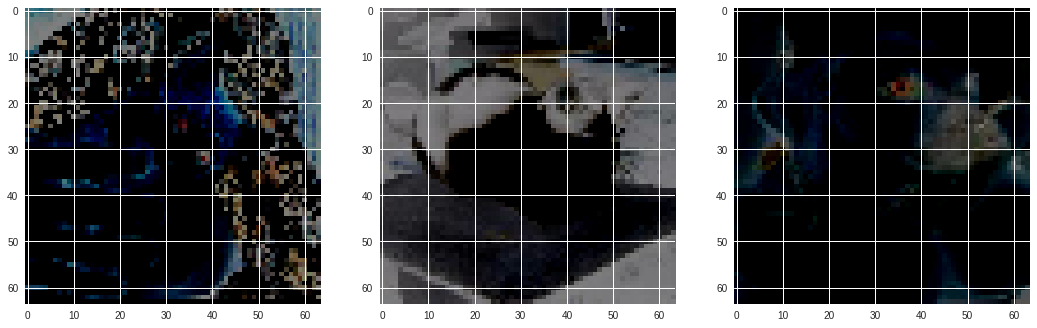

In [159]:
model= 'model1'
plt.figure( figsize=(18, 8))
for pos in range(3):
  plt.subplot(1, 3, pos+1)
  fail_img = X_test[imgPredFailure_dict[model][pos]]
  plt.imshow(fail_img)

***

<font color=#ad3e26>
Write a small report summarizing the network choices you have tried, what worked and what didn't. What have you learned from this experience?</font>

***

## Sum-up & Conclusions

<br><li>Confusion Matrix</li>

<br><li>Se guardan en un diccionario las matrices de confusion.</li>

In [0]:
cmDict={
    model: confusion_matrix(df_predict['test'],df_predict[model])
    for model in modelList
}

<li>Se plotean las matrices de confusión</li>

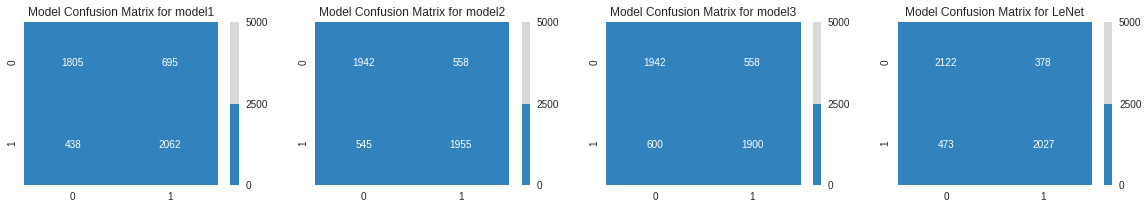

In [162]:
plt.figure( figsize=(20, 3))
plt.subplot(1,4,1)
plot_confusion_matrix(cm=cmDict[modelList[0]], dim=len(y_test_orig), model=modelList[0])
plt.subplot(1,4,2)
plot_confusion_matrix(cm=cmDict[modelList[1]], dim=len(y_test_orig), model=modelList[1])
plt.subplot(1,4,3)
plot_confusion_matrix(cm=cmDict[modelList[2]], dim=len(y_test_orig), model=modelList[2])
plt.subplot(1,4,4)
plot_confusion_matrix(cm=cmDict[modelList[3]], dim=len(y_test_orig), model=modelList[3])
plt.show()

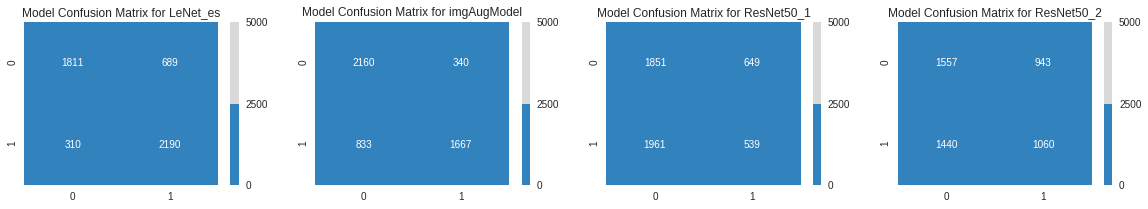

In [164]:
plt.figure( figsize=(20, 3))
plt.subplot(1,4,1)
plot_confusion_matrix(cm=cmDict[modelList[4]], dim=len(y_test_orig), model=modelList[4])
plt.subplot(1,4,2)
plot_confusion_matrix(cm=cmDict[modelList[5]], dim=len(y_test_orig), model=modelList[5])
plt.subplot(1,4,3)
plot_confusion_matrix(cm=cmDict[modelList[6]], dim=len(y_test_orig), model=modelList[6])
plt.subplot(1,4,4)
plot_confusion_matrix(cm=cmDict[modelList[7]], dim=len(y_test_orig), model=modelList[7])
plt.show()

<br><li>Performance</li>

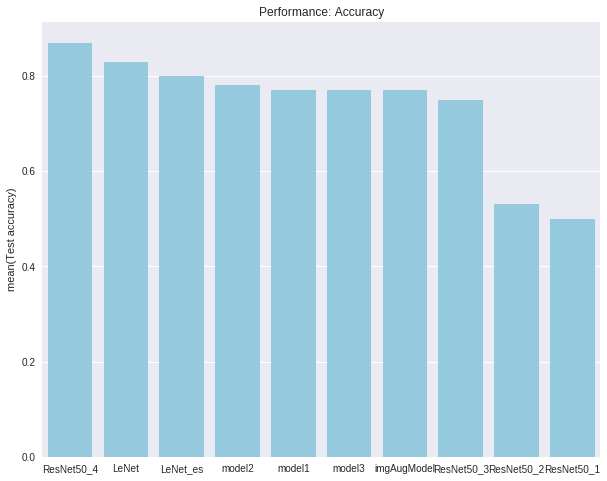

In [165]:
df_score_plot=df_score.T
df_score_plot.sort_values(by='Test accuracy',ascending=False, inplace=True)
plt.figure( figsize=(10, 8))
plt.title('Performance: Accuracy')
_=sns.barplot(x=df_score_plot.index, y=round(df_score_plot['Test accuracy'],2),color='skyblue')

<br><li>Se plotea la relación accuracy *vs* loss fnc</li>

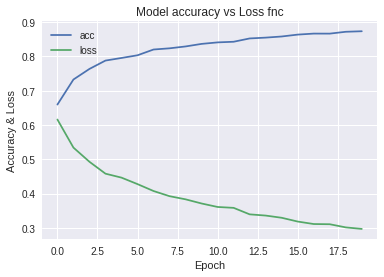

In [167]:
# Plot training & validation accuracy values
plt.plot(df_epochs_model1['acc'])
plt.plot(df_epochs_model1['loss'])
plt.title('Model accuracy vs Loss fnc')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(['acc', 'loss'], loc='upper left')
plt.show()



A la vista de las gráficas se pueden extraer ciertas consideraciones.

+ 1. El mejor modelo es *ResNet50_4*.
+ 2. Se han aplicado técnicas que tendrían que mejorar el modelo anterior.
> 2.1 model1,2,3. Modelos simples.<br>
> 2.2 LeNet. Un modelo más complejo que los 3 primeros (que además se construyeron aleatoriamente sin ningún tipo de prueba error).<br>
> 2.3 LeNet_es. Modelo LeNet + aplicación de EarlyStopping, que evita el overfitting al detener el entrenamiento antes del sobre ajuste.<br>
> 2.4 imgAugModel. modelo2 + aplicación de técnicas de generación de patrones nuevos, que busca aumentar el número de patrones del data set de entrenamiento dándole una mayor aleatoriedad al modelo.<br>
> 2.5 ResNet50_1. Modelo pre-entrenado ResNet50, modelo con técnicas de *residuals conections*, y entrenamiento con técnicas de congelación de las capas convolucionales del modelo base. Estos modelo son muy complejos con muy bue performance ya probados. <br>
> 2.6 ResNet50_2.  Modelo pre-entrenado ResNet50_1 + entrenamiento del modelo completo, que refina el modelo anterior con el entrenamiento del modelo global.<br>
> 2.7 ResNet50_3. Modelo pre-entrenado ResNet50_1 + capa densa (500) + activaión *ReLu*, que da una mayor complejidad al modelo en la parte de adaptación al nuevo data set de estudio.  <br>
> 2.8 ResNet50_4.Modelo pre-entrenado ResNet50_3 + entrenamiento del modelo completo, suma de las dos mejoras anteriores.<br>
+ 3. Hay ciertas mejoras que no han funcionado como se esperaban:
>> 3.1 La técnica de early stopping. Podrías ser porque el modelo no llega al overfitting con el número de épocas de la configuración del modelo (realtivamente pocas por temas de computación)
>> 3.2 La generacón de patrones nuevos. Una causa podría ser que esta es una técnica para data set pequeños y en este caso puede considerarse suficiente.
>> 3.3 La utilización del modelo pre-entreando solo ha funcionado cuando se ha metido una capa densa posterior. ha mejorado mucho.
+ 4. Se podría mejorar el coste de computación analizando el incremento de la función de perdida en la optimización de cada época para ajustar el parámetro *min_delta*. Para ello se plotea el valor de la función de perdida en cada época.
+5. Se podría observar si el modelo sobre entrena analizando la gráfica *accuracy* en test *vs* *accuracy* en train época a época. De tal manera que se podría intervenir en el modelo deteniéndolo para mejorar el accuraccy en test.